### Research Questions
#### RQ1-1: How does different line selection methods affect the FL accuracy of MLP?
* lines selection methods:
    * allfails: selecting all lines executed by failing test cases.
    * random-50: randomly selecting 50% of lines amongst lines executed by failing test cases.
    * sbfl-based-50: selecing top 50% lines based on naish2 suspicious score amongst lines executed by failing test cases.
#### RQ1-2: How does the amount of selected lines affect the FL accuracy of MLP?
* Different amount settings for sbfl-based line selection method:
    * allfails-100: selecting 100% of lines executed by failing test cases.
    * sbfl-based-50: selecting top 50% lines based on naish2 suspicious score amongst lines executed by failing test cases.
    * sbfl-based-30: selecting top 30% lines based on naish2 suspicious score amongst lines executed by failing test cases.
    * sbfl-based-10: selecting top 10% lines based on naish2 suspicious score amongst lines executed by failing test cases.
#### RQ2: How does the number of mutants utilized per line affect the FL accuracy of MLP?
* Variation of controlling the number of mutants utilized per line:
    * sbfl-based-max: utilize maximum (10) mutants per line amongst lines executed by failing test cases and lines which rank at top 50% based on naish2.
    * sbfl-based-reduced: utilize reduced (6) mutants per line amongst lines executed by failing test cases and lines which rank at top 50% based on naish2.
    * sbfl-based-variation: utilize varation amount of mutants per line amongst lines executed by failing test cases by their naish2 suspicious score:
        * top 33%: 10 mutants
        * below 33% and above 66%: 6 mutants
        * below 66%: 2 mutants
    * sbfl-based-min: utilize minimum (2) mutants per line amongst lines executed by failing test cases and lines which rank at top 50% based on naish2.
#### RQ3: How does including coincidentally-correct-test-cases (CCTs) affect the FL accuracy of MLP?
* sbfl-based-50-withoutCCT, sbfl-based-50-withCCT

In [1]:
from pathlib import Path
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import shutil
import os
import sys

CURR_FILE = Path("./").resolve()
OUT_DIR = CURR_FILE.parent / "out"
assert OUT_DIR.exists()
RQ_RESULTS_DIR = CURR_FILE.parent / "rq_results"
assert RQ_RESULTS_DIR.exists()

SHAPE_SIZE = 10

SUBJECTS = [
    "zlib_ng_exp1",
    "libxml2_exp1",
    "opencv_features2d_exp1",
    "opencv_imgproc_exp1",
    "opencv_core_exp1",
    "jsoncpp_exp1",
]

RQ1_1 = [
    ["allfails-maxMutants-excludeCCT", "allfails"],
    ["rand50-maxMutants-excludeCCT", "random-50"],
    ["sbflnaish250-maxMutants-excludeCCT", "sbfl-based-50"]
]

RQ1_2 = [
    ["allfails-maxMutants-excludeCCT", "sbfl-based-100"],
    ["sbflnaish250-maxMutants-excludeCCT", "sbfl-based-50"],
    ["sbflnaish230-maxMutants-excludeCCT", "sbfl-based-30"],
    ["sbflnaish220-maxMutants-excludeCCT", "sbfl-based-20"],
    ["sbflnaish210-maxMutants-excludeCCT", "sbfl-based-10"],
    ["sbflnaish201-maxMutants-excludeCCT", "sbfl-based-1"],
    ["sbflnaish200-maxMutants-excludeCCT", "sbfl-based-0"]
]


RQ2_30 = [
    ["allfails-maxMutants-excludeCCT", "allfails-10mut"],
    ["sbflnaish230-maxMutants-excludeCCT", "sbfl30-10mut"],
    # ["sbflnaish230-reduced7Mutants-excludeCCT", "sbfl30-7mut"],
    ["sbflnaish230-reduced5Mutants-excludeCCT", "sbfl30-5mut"],
    ["sbflnaish230-reduced3Mutants-excludeCCT", "sbfl30-3mut"],
    ["sbflnaish230-reduced1Mutants-excludeCCT", "sbfl30-1mut"]
]

RQ2_20 = [
    ["allfails-maxMutants-excludeCCT", "allfails-10mut"],
    ["sbflnaish220-maxMutants-excludeCCT", "sbfl20-10mut"],
    # ["sbflnaish220-reduced7Mutants-excludeCCT", "sbfl20-7mut"],
    ["sbflnaish220-reduced5Mutants-excludeCCT", "sbfl20-5mut"],
    ["sbflnaish220-reduced3Mutants-excludeCCT", "sbfl20-3mut"],
    ["sbflnaish220-reduced1Mutants-excludeCCT", "sbfl20-1mut"]
]

RQ2_10 = [
    ["allfails-maxMutants-excludeCCT", "allfails-10mut"],
    ["sbflnaish210-maxMutants-excludeCCT", "sbfl10-10mut"],
    # ["sbflnaish210-reduced7Mutants-excludeCCT", "sbfl10-7mut"],
    ["sbflnaish210-reduced5Mutants-excludeCCT", "sbfl10-5mut"],
    ["sbflnaish210-reduced3Mutants-excludeCCT", "sbfl10-3mut"],
    ["sbflnaish210-reduced1Mutants-excludeCCT", "sbfl10-1mut"],
    ["sbflnaish210-noMutants-excludeCCT", "sbfl10-0mut"],
]

RQ3 = [
    # ["allfails-maxMutants-excludeCCT", "allfails-ten-Mutants-withoutCCTs"],
    ["sbflnaish210-reduced1Mutants-excludeCCT", "withoutCCTs"],
    ["sbflnaish210-reduced1Mutants-withCCT", "withCCTs"]
]

RQ4_10_branch = [
    ["allfails-maxMutants-excludeCCT", "allfails-10mut-allPass"],
    ["sbflnaish210-reduced1Mutants-excludeCCT", "all-passings"],
    ["sbflnaish210-reduced1Mutants-excludeCCT-reducedTCBranchCov50", "brSim-50-passings"],
    ["sbflnaish210-reduced1Mutants-excludeCCT-reducedTCBranchCov30", "brSim-30-passings"],
    ["sbflnaish210-reduced1Mutants-excludeCCT-reducedTCBranchCov10", "brSim-10-passings"],
]

RQ4_20_branch = [
    ["allfails-maxMutants-excludeCCT", "allfails-10mut-allPass"],
    ["sbflnaish220-reduced3Mutants-excludeCCT-reducedTCBranchCov70", "sbfl20-3mut-brSim70"],
    ["sbflnaish220-reduced3Mutants-excludeCCT-reducedTCBranchCov50", "sbfl20-3mut-brSim50"],
    ["sbflnaish220-reduced3Mutants-excludeCCT-reducedTCBranchCov30", "sbfl20-3mut-brSim30"],
    ["sbflnaish220-reduced3Mutants-excludeCCT-reducedTCBranchCov10", "sbfl20-3mut-brSim10"],
]

RQ4_20_random = [
    ["allfails-maxMutants-excludeCCT", "allfails-10mut-allPass"],
    ["sbflnaish220-reduced3Mutants-excludeCCT-reducedRandom70", "sbfl20-3mut-rand70"],
    ["sbflnaish220-reduced3Mutants-excludeCCT-reducedRandom50", "sbfl20-3mut-rand50"],
    ["sbflnaish220-reduced3Mutants-excludeCCT-reducedRandom30", "sbfl20-3mut-rand30"],
    ["sbflnaish220-reduced3Mutants-excludeCCT-reducedRandom10", "sbfl20-3mut-rand10"],
]

# EXPERIMENT_KEYS = {
#     "allfails-maxMutants-excludeCCT": "allfails-noReduced-excludeCCT-noHeuristics",
#     "rand50-maxMutants-excludeCCT": "rand50-noReduced-excludeCCT-noHeuristics",
#     "sbflnaish250-maxMutants-excludeCCT": "sbflnaish250-noReduced-excludeCCT-noHeuristics",
#     "sbflnaish230-maxMutants-excludeCCT": "sbflnaish230-noReduced-excludeCCT-noHeuristics",
#     "sbflnaish210-maxMutants-excludeCCT": "sbflnaish210-noReduced-excludeCCT-noHeuristics",
#     "sbflnaish201-maxMutants-excludeCCT": "sbflnaish201-noReduced-excludeCCT-noHeuristics",
#     "sbflnaish200-maxMutants-excludeCCT": "sbflnaish200-noReduced-excludeCCT-noHeuristics",
#     "sbflnaish250-reducedAvg-excludeCCT": "sbflnaish250-reduced-excludeCCT-noHeuristics",
#     "sbflnaish250-reducedSbflnaish2-excludeCCT": "sbflnaish250-reduced_sbflnaish2-excludeCCT-noHeuristics",
#     "sbflnaish250-reducedMinMutants-excludeCCT": "sbflnaish250-reduced_min-excludeCCT-noHeuristics",
#     "sbflnaish250-maxMutants-withCCT": "sbflnaish250-noReduced-withCCT-noHeuristics"
# }


In [2]:
def get_acc(fl_acc_txt):
    with open(fl_acc_txt, "r") as fp:
        lines = fp.readlines()
        acc5 = float(lines[2].strip().split(": ")[-1])
        acc10 = float(lines[4].strip().split(": ")[-1])
    return acc5, acc10

def rewrite(rq):
    for subject in SUBJECTS:
        subject_dir = OUT_DIR / subject / "analysis/ml"
        assert subject_dir.exists()

        for method in rq:
            method_dir = subject_dir / method
            assert method_dir.exists()

            result_csv = method_dir / "results.csv"
            result_fp = open(result_csv, "w")
            result_fp.write("analysis_type,shape,test_acc5,test_acc10,self_acc5,self_acc10\n")

            results = {}
            for i in range(SHAPE_SIZE):
                shape_dir = method_dir / f"shape{i+1}"
                assert shape_dir.exists()
                inference_dir = shape_dir / "inference"
                assert inference_dir.exists()
                test_dir = inference_dir / "opencv_calib3d-D0"
                assert test_dir.exists()
                self_dir = inference_dir / "self"
                assert self_dir.exists()

                method_name = method_dir.name
                shape_name = shape_dir.name
                test_acc5, test_acc10 = get_acc(test_dir / "fl_acc.txt")
                self_acc5, self_acc10 = get_acc(self_dir / "fl_acc.txt")

                result_fp.write(f"{method_name},{shape_name},{test_acc5},{test_acc10},{self_acc5},{self_acc10}\n")



In [3]:
def return_data(rq):
    subjects2method2result = {}
    for subject in SUBJECTS:
        subject_dir = OUT_DIR / subject / "analysis/ml"
        assert subject_dir.exists()

        subjects2method2result[subject] = {}

        for method, method_name in rq:
            method_dir = subject_dir / method
            if not method_dir.exists():
                print(f"Skipping {subject} - {method}\n{method_dir} does not exist")
            assert method_dir.exists()

            result_csv = method_dir / "results.csv"
            if not result_csv.exists():
                print(f"Skipping {subject} - {method}\n{result_csv} does not exist")
            assert result_csv.exists()

            subjects2method2result[subject][method_name] = {
                "test_acc5": [],
                "test_acc10": [],
                "self_acc5": [],
                "self_acc10": []
            }

            with open(result_csv, "r") as f:
                reader = csv.reader(f)
                header = next(reader)
                for row in reader:
                    analysis_type = row[0]
                    shape = row[1]
                    test_acc5 = float(row[2])
                    test_acc10 = float(row[3])
                    self_acc5 = float(row[4])
                    self_acc10 = float(row[5])

                    assert method == analysis_type

                    subjects2method2result[subject][method_name]["test_acc5"].append(test_acc5)
                    subjects2method2result[subject][method_name]["test_acc10"].append(test_acc10)
                    subjects2method2result[subject][method_name]["self_acc5"].append(self_acc5)
                    subjects2method2result[subject][method_name]["self_acc10"].append(self_acc10)
                
                assert len(subjects2method2result[subject][method_name]["test_acc5"]) == SHAPE_SIZE
                assert len(subjects2method2result[subject][method_name]["test_acc10"]) == SHAPE_SIZE
                assert len(subjects2method2result[subject][method_name]["self_acc5"]) == SHAPE_SIZE
                assert len(subjects2method2result[subject][method_name]["self_acc10"]) == SHAPE_SIZE

    return subjects2method2result

def plot_acc_graphs_grid(subjects2method2result, rq_dir):
    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
    axes = axes.flatten()

    for ax, (subject, method2results) in zip(axes, subjects2method2result.items()):
        ax.set_title(f"{subject} - Accuracy")
        ax.set_xlabel("MLP Shapes")
        ax.set_ylabel("FL Accuracy")
        ax.set_ylim([0.0, 1.0])

        shape_names = [f"shape{i+1}" for i in range(SHAPE_SIZE)]
        ax.set_xticks(range(len(shape_names)))
        ax.set_xticklabels(shape_names)
        for method_name, results in method2results.items():
            test_acc5 = results["test_acc5"]
            test_acc10 = results["test_acc10"]
            self_acc5 = results["self_acc5"]
            self_acc10 = results["self_acc10"]

            ax.plot(shape_names, test_acc10, marker="o", label=f"{method_name} test acc@10")

        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    fig.savefig(rq_dir / "acc_graphs_grid.png")

def show_average_acc_dataframe(subjects2method2result, rq_dir):
    # make dataframe where the columns are
    # subject, method, test_acc5, test_acc10, self_acc5, self_acc10
    # each accuracy is the average of the accuracies for the shapes

    data = []
    for subject, method2results in subjects2method2result.items():
        for method_name, results in method2results.items():
            test_acc5 = round((np.mean(results["test_acc5"])*100), 2)
            test_acc10 = round((np.mean(results["test_acc10"])*100), 2)
            self_acc5 = round((np.mean(results["self_acc5"])*100), 2)
            self_acc10 = round((np.mean(results["self_acc10"])*100), 2)
            data.append([subject, method_name, test_acc5, test_acc10, self_acc5, self_acc10])

    df = pd.DataFrame(data, columns=["subject", "method_name", "mlp_test_acc5", "mlp_test_acc10", "mlp_self_acc5", "mlp_self_acc10"])
    df.to_csv(rq_dir / "average_acc.csv", index=False)

    return df

def check_utilized_data_stats(rq, rq_dir):
    data = []
    for subject in SUBJECTS:
        subject_dir = OUT_DIR / subject / "analysis"
        assert subject_dir.exists()

        for method, method_name in rq:
            method_dir_name = method # EXPERIMENT_KEYS[method]
            method_dir = subject_dir / method_dir_name
            assert method_dir.exists()

            utilized_data_avg_stats_json = method_dir / "utilized_data_avg_stats.json"
            if not utilized_data_avg_stats_json.exists():
                print(f"Skipping {subject} - {method}\n{utilized_data_avg_stats_json} does not exist")
            assert utilized_data_avg_stats_json.exists()

            with open(utilized_data_avg_stats_json, "r") as f:
                utilized_data_avg_stats = json.load(f)

                avg_num_failing_tcs = round(utilized_data_avg_stats["avg_num_failing_tcs"], 2)
                avg_num_passing_tcs = round(utilized_data_avg_stats["avg_num_passing_tcs"], 2)
                avg_num_ccts = round(utilized_data_avg_stats["avg_num_ccts"], 2)
                avg_num_utilized_failing_tcs = round(utilized_data_avg_stats["avg_num_utilized_failing_tcs"], 2)
                avg_num_utilized_passing_tcs = round(utilized_data_avg_stats["avg_num_utilized_passing_tcs"], 2)
                avg_num_utilized_ccts = round(utilized_data_avg_stats["avg_num_utilized_ccts"], 2)
                avg_num_utilized_mutants = round(utilized_data_avg_stats["avg_num_utilized_mutants"], 2)
                avg_num_utilized_mutants_per_line = round(utilized_data_avg_stats["avg_num_utilized_mutants_per_line"], 2)
                avg_buggy_line_mut_cnt = round(utilized_data_avg_stats["avg_buggy_line_mut_cnt"], 2)
                avg_buggy_line_f2p = round(utilized_data_avg_stats["avg_buggy_line_f2p"], 2)
                avg_buggy_line_p2f = round(utilized_data_avg_stats["avg_buggy_line_p2f"], 2)
                avg_total_mut_build_time = round(utilized_data_avg_stats["avg_total_mut_build_time"], 2)
                avg_total_tc_exec_time = round(utilized_data_avg_stats["avg_total_tc_exec_time"], 2)
                avg_num_lines_execed_by_failing_tcs = round(utilized_data_avg_stats["avg_num_lines_executed_by_failing_tcs"], 2)
                avg_num_funcs_execed_by_failing_tcs = round(utilized_data_avg_stats["avg_num_funcs_executed_by_failing_tcs"], 2)

                data.append([
                    subject, method_name,
                    avg_num_failing_tcs, avg_num_passing_tcs, avg_num_ccts,
                    avg_num_utilized_failing_tcs, avg_num_utilized_passing_tcs, avg_num_utilized_ccts,
                    avg_num_utilized_mutants, avg_num_utilized_mutants_per_line, avg_buggy_line_mut_cnt,
                    avg_buggy_line_f2p, avg_buggy_line_p2f, avg_total_mut_build_time,
                    avg_total_tc_exec_time, avg_num_lines_execed_by_failing_tcs,
                    avg_num_funcs_execed_by_failing_tcs
                ])

    df = pd.DataFrame(data, columns=[
        "subject", "method_name", 
        "avg_num_failing_tcs", "avg_num_passing_tcs", "avg_num_ccts",
        "avg_num_utilized_failing_tcs", "avg_num_utilized_passing_tcs", "avg_num_utilized_ccts",
        "avg_num_utilized_mutants", "avg_num_utilized_mutants_per_line", "avg_buggy_line_mut_cnt",
        "avg_buggy_line_f2p", "avg_buggy_line_p2f", "avg_total_mut_build_time",
        "avg_total_tcs_exec_time", "avg_num_lines_executed_by_failing_tcs",
        "avg_num_funcs_executed_by_failing_tcs"
    ])
    df.to_csv(rq_dir / "mutation_stats.csv", index=False)
    return df

def check_mbfl_acc_time(rq, rq_dir):
    results = {}
    for subject in SUBJECTS:
        subject_dir = OUT_DIR / subject / "analysis"
        assert subject_dir.exists()

        results[subject] = {}

        for i, [method, method_name] in enumerate(rq):
            method_dir_name = method
            method_dir = subject_dir / method_dir_name
            assert method_dir.exists()

            mbfl_overall_data_json = method_dir / "mbfl_overall_data.json"
            mbfl_overall_data = json.loads(mbfl_overall_data_json.read_text())

            for key, data in mbfl_overall_data.items():
                met_acc5, met_acc10, muse_5, muse_10 = 0, 0, 0, 0
                time_duration_list = []

                for version_name, version_data in data.items():
                    met_rank = version_data[0]["met_rank"]
                    muse_rank = version_data[0]["muse_rank"]

                    tot_build_time = version_data[0]["total_build_time"]
                    tot_tc_exec_time = version_data[0]["total_tc_execution_time"]
                    total_time_duration = (tot_build_time + tot_tc_exec_time) / 3600
                    time_duration_list.append(total_time_duration)

                    if met_rank <= 5:
                        met_acc5 += 1
                    if met_rank <= 10:
                        met_acc10 += 1
                    if muse_rank <= 5:
                        muse_5 += 1
                    if muse_rank <= 10:
                        muse_10 += 1
                
                met_acc5 /= len(data)
                met_acc10 /= len(data)
                muse_5 /= len(data)
                muse_10 /= len(data)
                avg_time_duration = np.mean(time_duration_list)

                if i == 0:
                    rel_time_diff = 0.0
                else:
                    rel_time_diff = ((avg_time_duration - results[subject][rq[0][1]]["avg_time_duration"]) / results[subject][rq[0][1]]["avg_time_duration"]) * 100

                results[subject][method_name] = {
                    "met_acc5": met_acc5,
                    "met_acc10": met_acc10,
                    "muse_acc5": muse_5,
                    "muse_acc10": muse_10,
                    "avg_time_duration": avg_time_duration,
                    "rel_time_diff": rel_time_diff
                }

    with open(rq_dir / "mbfl_scores.csv", "w") as f:
        f.write("subject,method_name,met_acc5,met_acc10,muse_acc5,muse_acc10,avg_time_duration,rel_time_diff\n")
        for subject, method2results in results.items():
            for method_name, result in method2results.items():
                met_acc5 = round((result["met_acc5"]*100), 2)
                met_acc10 = round((result["met_acc10"]*100), 2)
                muse_acc5 = round((result["muse_acc5"]*100), 2)
                muse_acc10 = round((result["muse_acc10"]*100), 2)
                avg_time_duration = round(result["avg_time_duration"], 2)
                rel_time_diff = round(result["rel_time_diff"], 2)
                f.write(f"{subject},{method_name},{met_acc5},{met_acc10},{muse_acc5},{muse_acc10},{avg_time_duration},{rel_time_diff}\n")


    # Create a grid of subplots
    fig, ax = plt.subplots()
    bar_width = 0.2
    index = range(len(SUBJECTS))
    colors = ["r", "g", "b", "y", "m", "c", "k"]
    colors = colors[:len(rq)]

    for i, [method, method_name] in enumerate(rq):
        avg_time_durations = [results[subject][method_name]["avg_time_duration"] for subject in SUBJECTS]
        ax.bar([x+bar_width*i for x in index], avg_time_durations, bar_width, label=method_name, color=colors[i])

    ax.set_title("MBFL Time Duration")
    ax.set_xlabel("Subjects")
    ax.set_ylabel("Average Time Duration (hours)")
    ax.set_xticks([x+bar_width for x in index])
    ax.set_xticklabels(SUBJECTS, rotation=45, ha="right")
    ax.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    fig.savefig(rq_dir / "mbfl_time_duration.png")

    df = pd.read_csv(rq_dir / "mbfl_scores.csv")
    return df

def check_sbfl_acc(rq, rq_dir):
    results = {}
    for subject in SUBJECTS:
        subject_dir = OUT_DIR / subject / "analysis"
        assert subject_dir.exists()

        results[subject] = {}

        sbfl_line_top_percentages = []
        for method, method_name in rq:
            method_dir_name = method # EXPERIMENT_KEYS[method]
            method_dir = subject_dir / method_dir_name
            assert method_dir.exists()

            sbfl_rank_data_json = method_dir / "sbfl_rank.json"
            sbfl_rank_data = json.loads(sbfl_rank_data_json.read_text())

            acc_5, acc_10 = 0, 0
            for key, data in sbfl_rank_data.items():
                rank = data["sbfl_rank"]
                sbfl_line_top_percentages.append(data["sbfl_line_top_percent"])
                if rank <= 5:
                    acc_5 += 1
                if rank <= 10:
                    acc_10 += 1

            acc_5 /= len(sbfl_rank_data)
            acc_10 /= len(sbfl_rank_data)

            avg_sbfl_line_top_perc = np.mean(sbfl_line_top_percentages)
            results[subject][method_name] = {
                "acc5": acc_5,
                "acc10": acc_10,
                "avg_sbfl_line_top_perc": avg_sbfl_line_top_perc
            }

    with open(rq_dir / "sbfl_scores.csv", "w") as f:
        f.write("subject,method_name,naish2_acc5,naish2_acc10,avg_line_top_perc\n")
        for subject, method2results in results.items():
            for method_name, result in method2results.items():
                acc5 = round((result["acc5"]*100), 2)
                acc10 = round((result["acc10"]*100), 2)
                avg_line_top_perc = round(result["avg_sbfl_line_top_perc"], 2)
                f.write(f"{subject},{method_name},{acc5},{acc10},{avg_line_top_perc}\n")

    df = pd.read_csv(rq_dir / "sbfl_scores.csv")
    return df


def check_rq(rq, rq_name):
    rq_name = f"{rq_name}"
    rq_dir = RQ_RESULTS_DIR / rq_name
    if rq_dir.exists():
        shutil.rmtree(rq_dir)
    rq_dir.mkdir(parents=True, exist_ok=True)

    # MLP accuracy
    subjects2method2result = return_data(rq)
    plot_acc_graphs_grid(subjects2method2result, rq_dir)
    avg_acc_df = show_average_acc_dataframe(subjects2method2result, rq_dir)

    # Mutation stats
    mut_stat_df = check_utilized_data_stats(rq, rq_dir)
    
    # MBFL accuracy and MBFL extraction time
    mbfl_score_df = check_mbfl_acc_time(rq, rq_dir)

    # SBFL accuracy
    sbfl_score_df = check_sbfl_acc(rq, rq_dir)

    # combine avg_acc_df, mut_stat_df, mbfl_score_df, sbfl_score_df
    # The all have the same subject, method columns
    combined_df = pd.merge(avg_acc_df, mut_stat_df, on=["subject", "method_name"])
    combined_df = pd.merge(combined_df, mbfl_score_df, on=["subject", "method_name"])
    combined_df = pd.merge(combined_df, sbfl_score_df, on=["subject", "method_name"])
    combined_df.to_csv(rq_dir / "combined_results.csv", index=False)

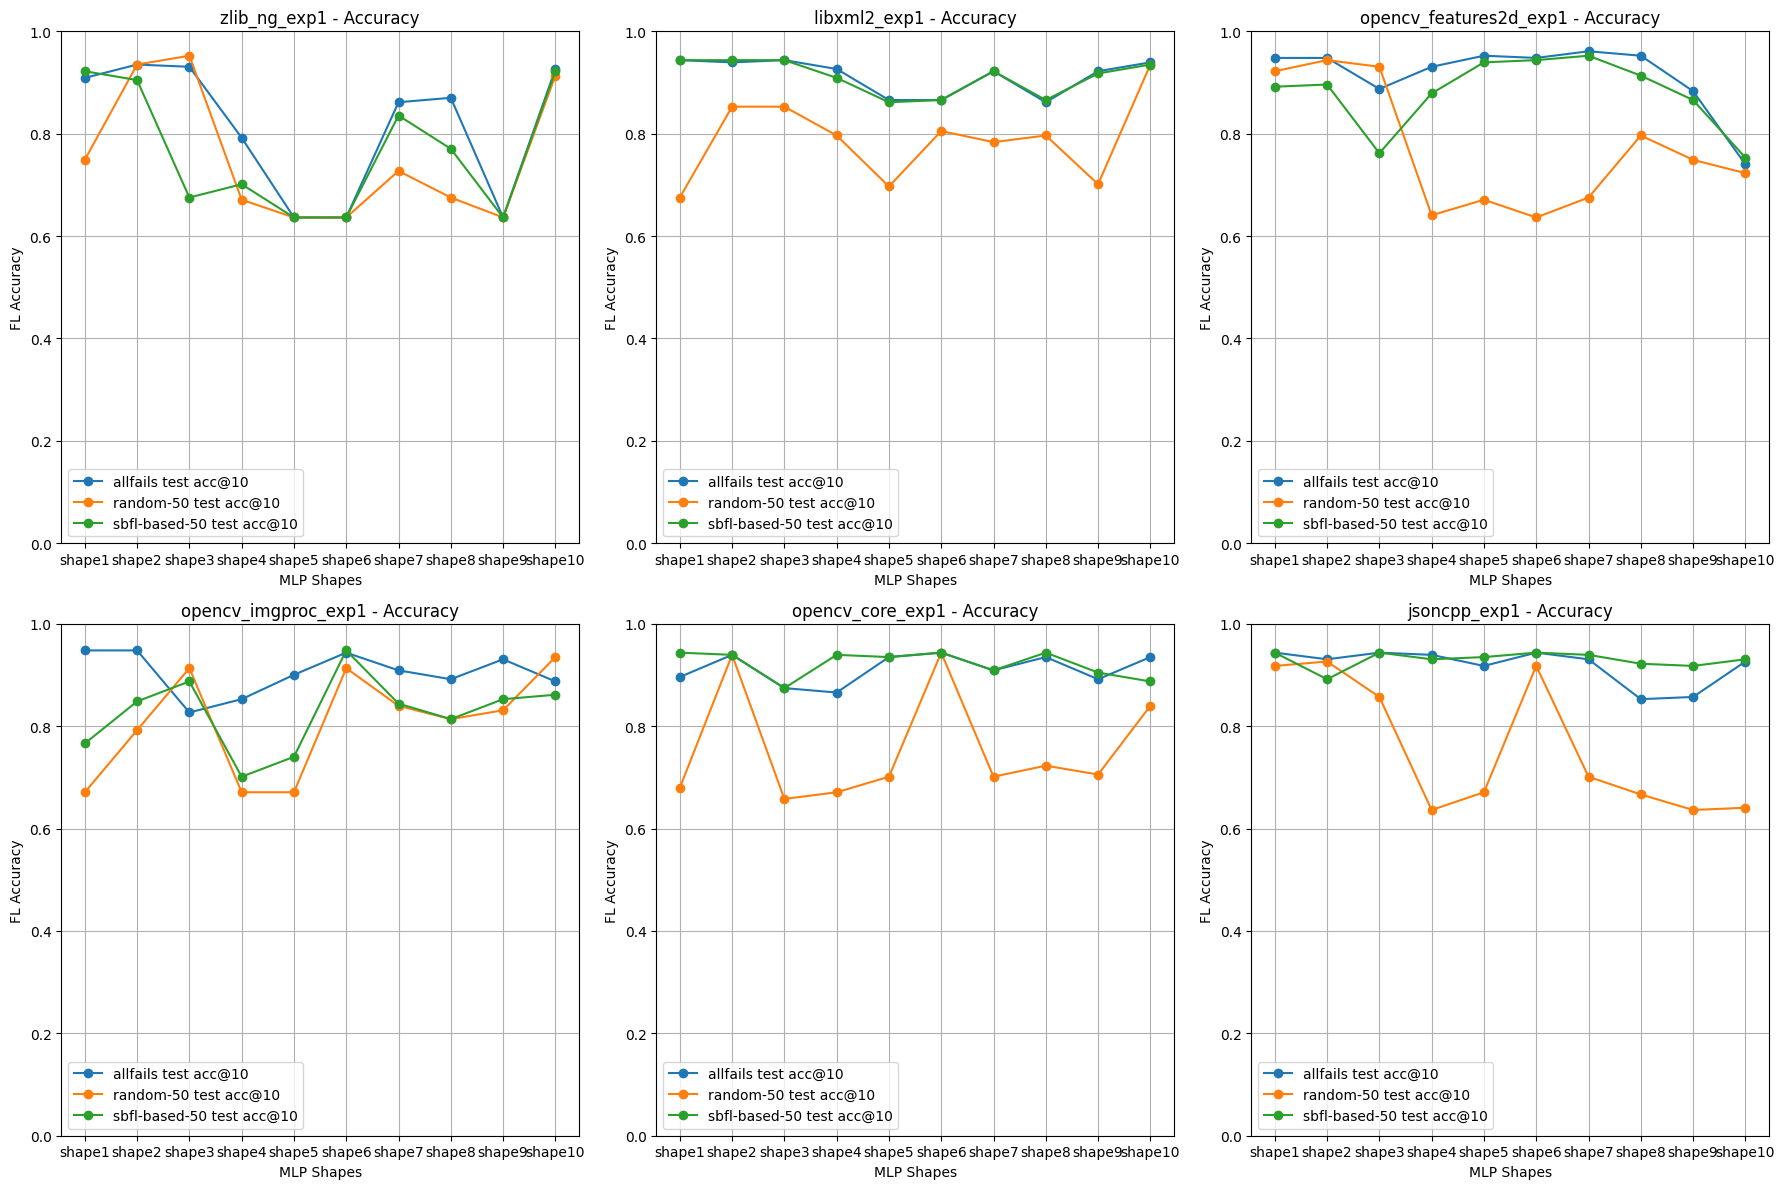

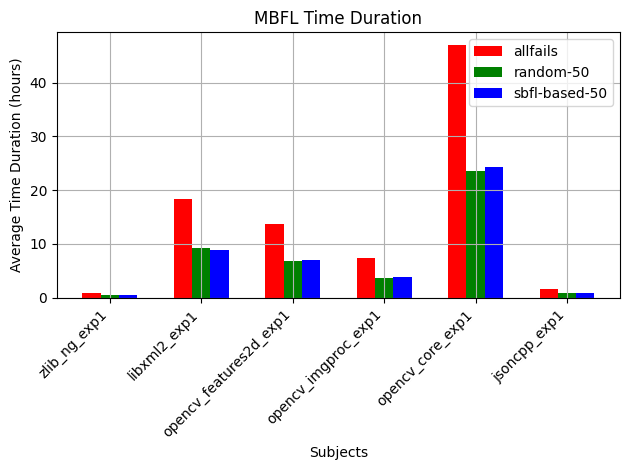

In [4]:
# RQ1-1 Line Selection Method
check_rq(RQ1_1, "RQ1_1")

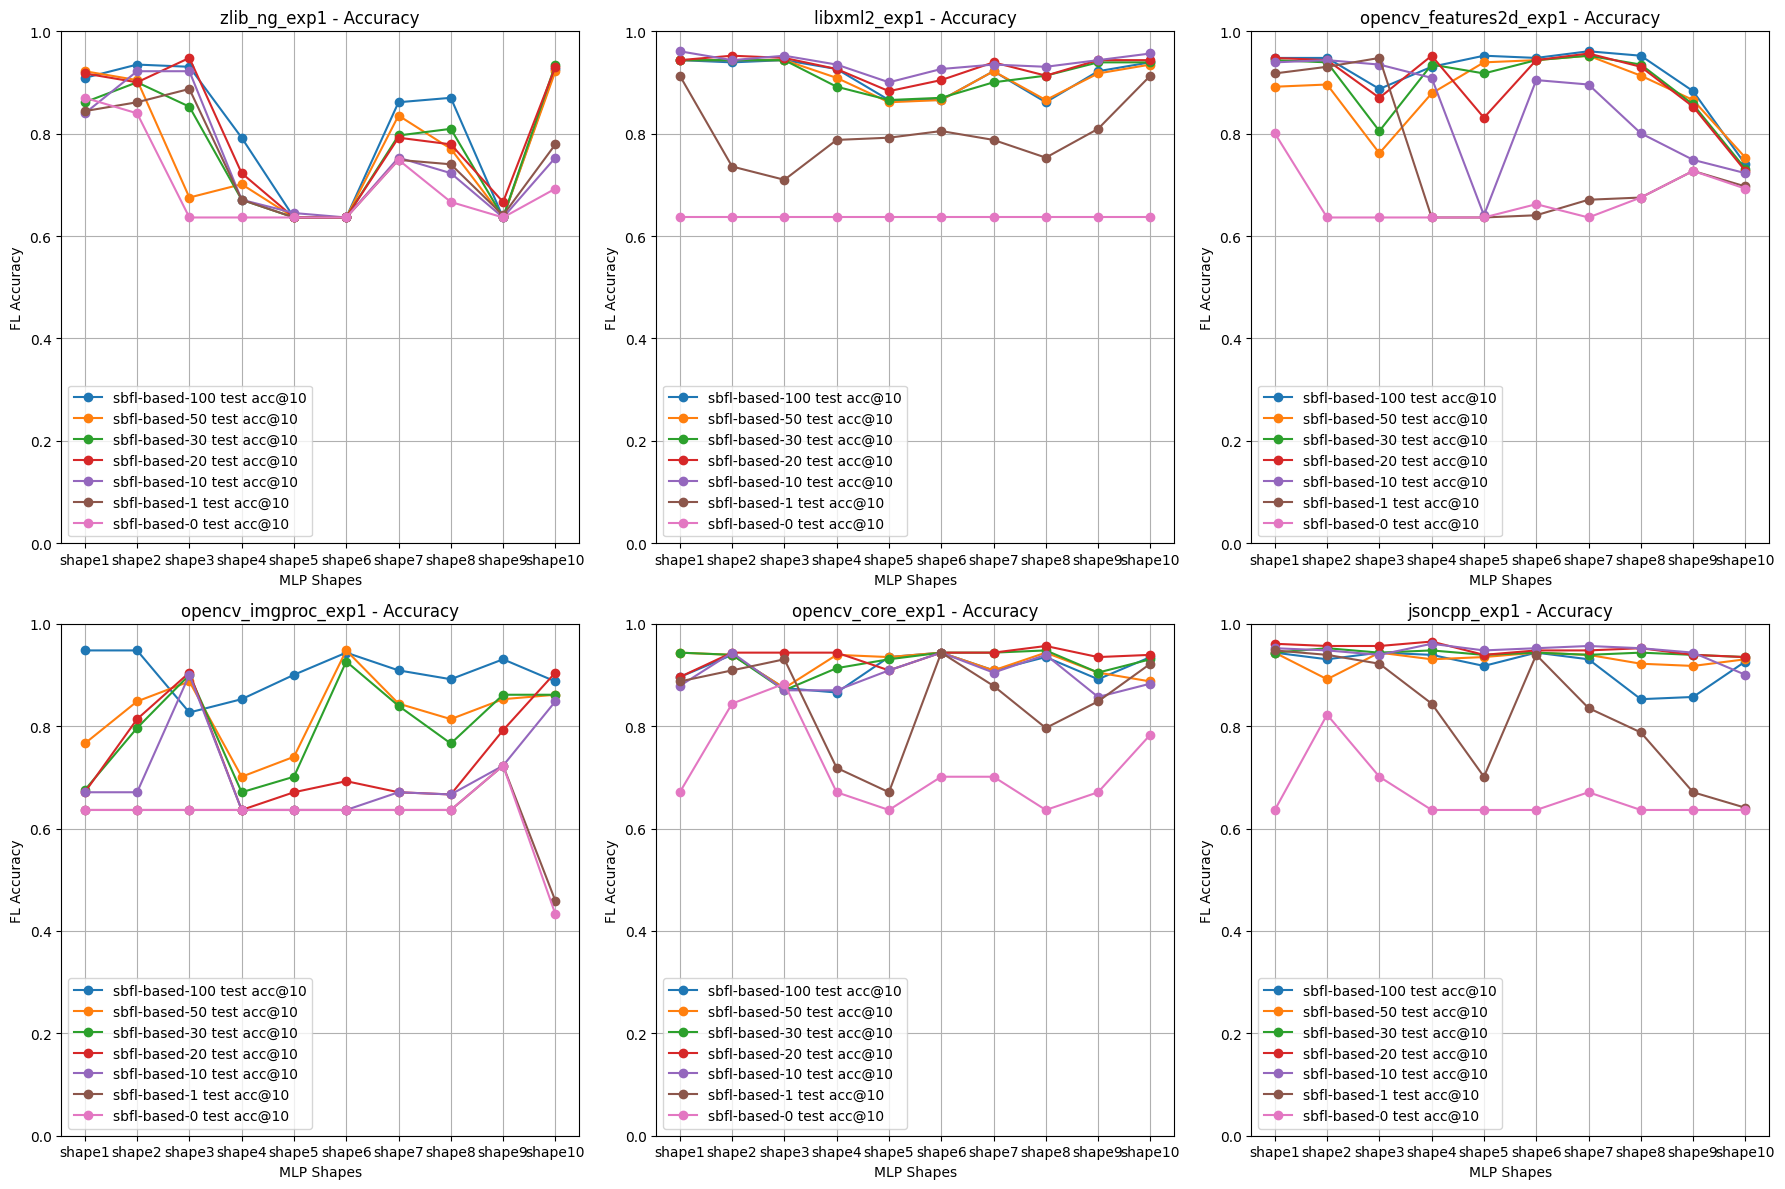

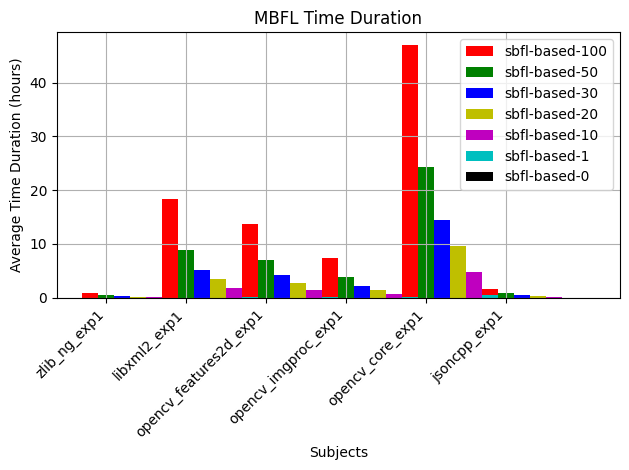

In [5]:
# RQ1-2 Line Selection Amount
check_rq(RQ1_2, "RQ1_2")

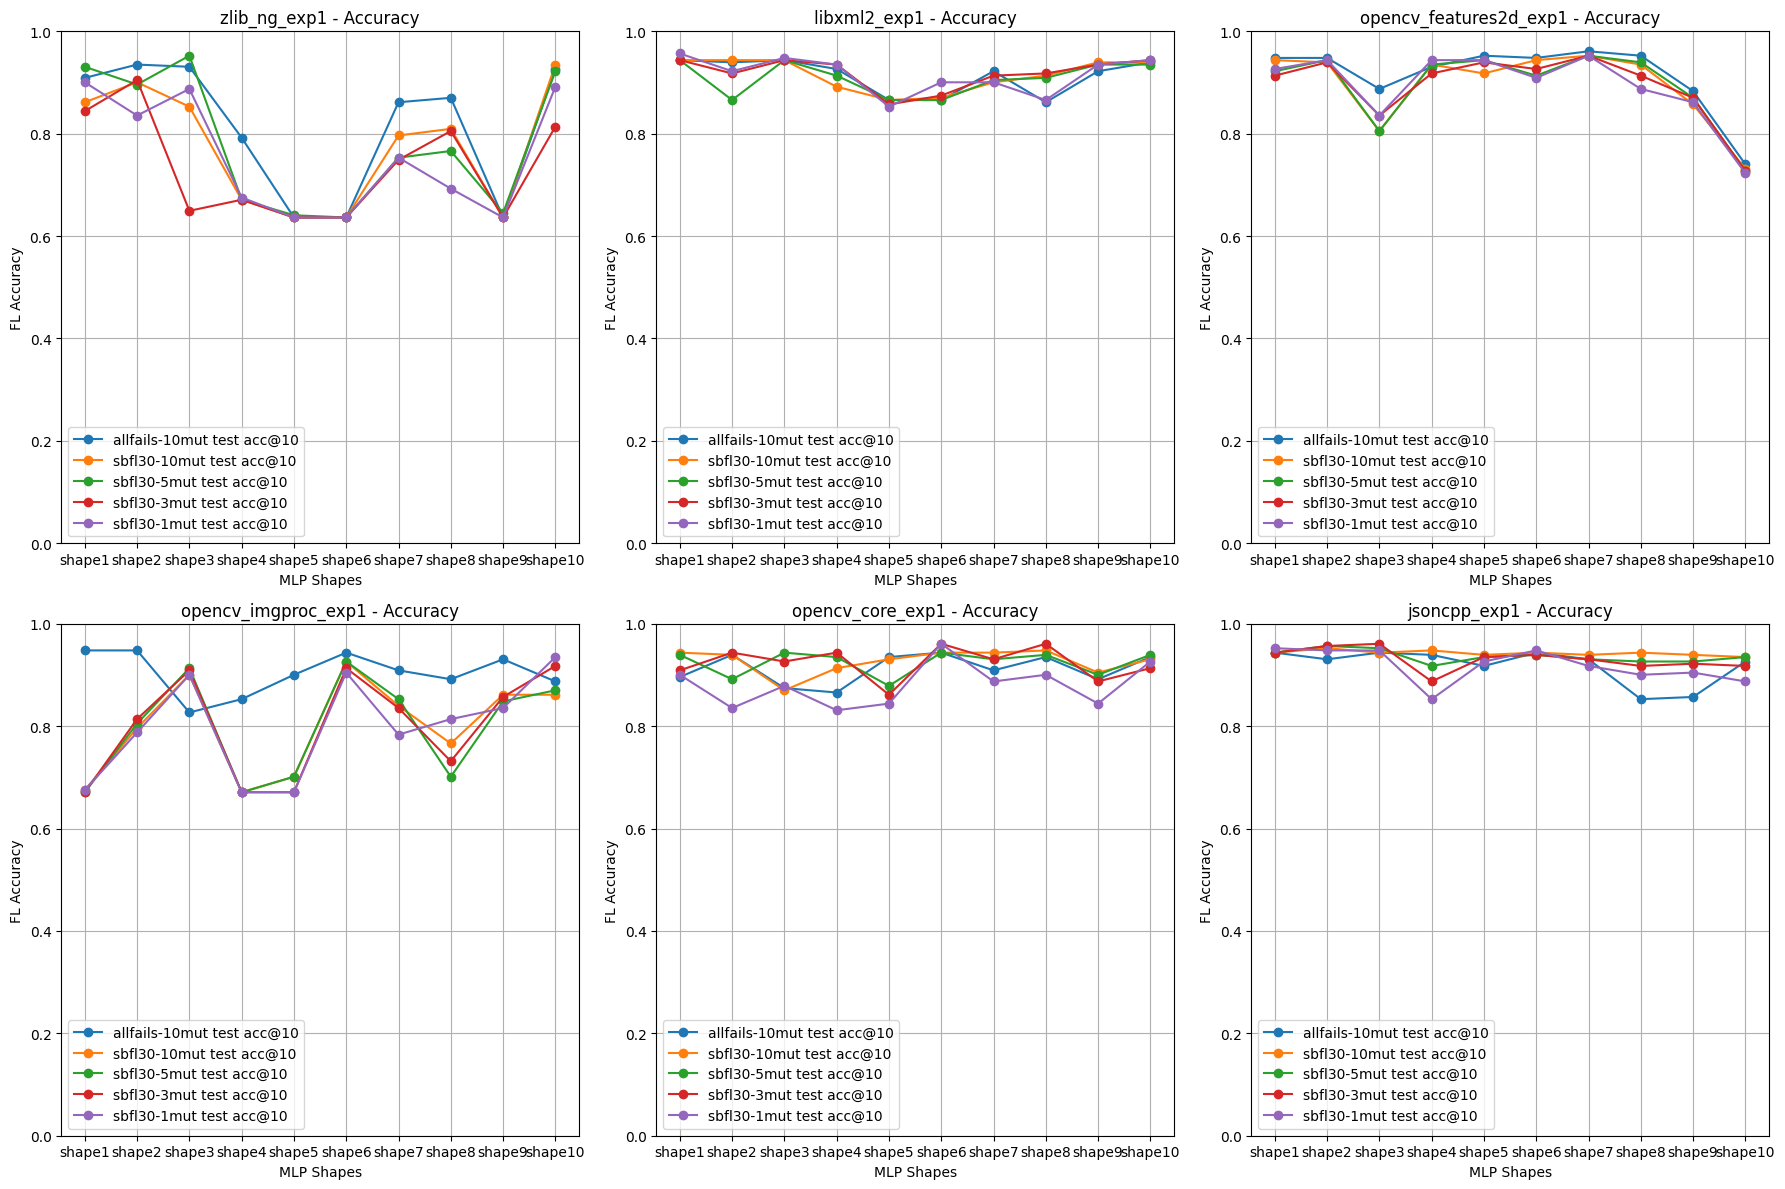

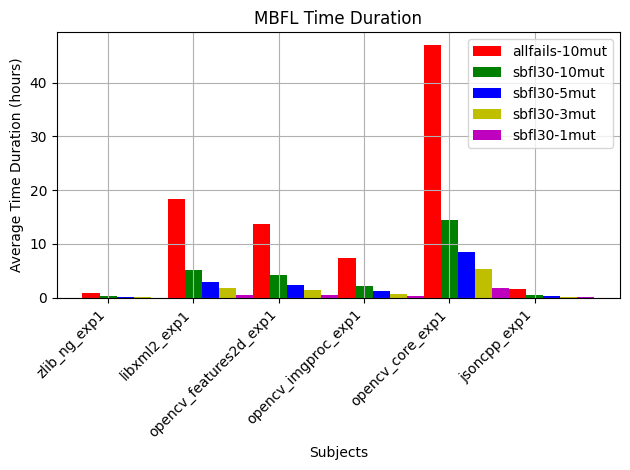

In [6]:
# RQ2: Number of Mutants Control
check_rq(RQ2_30, "RQ2_30")

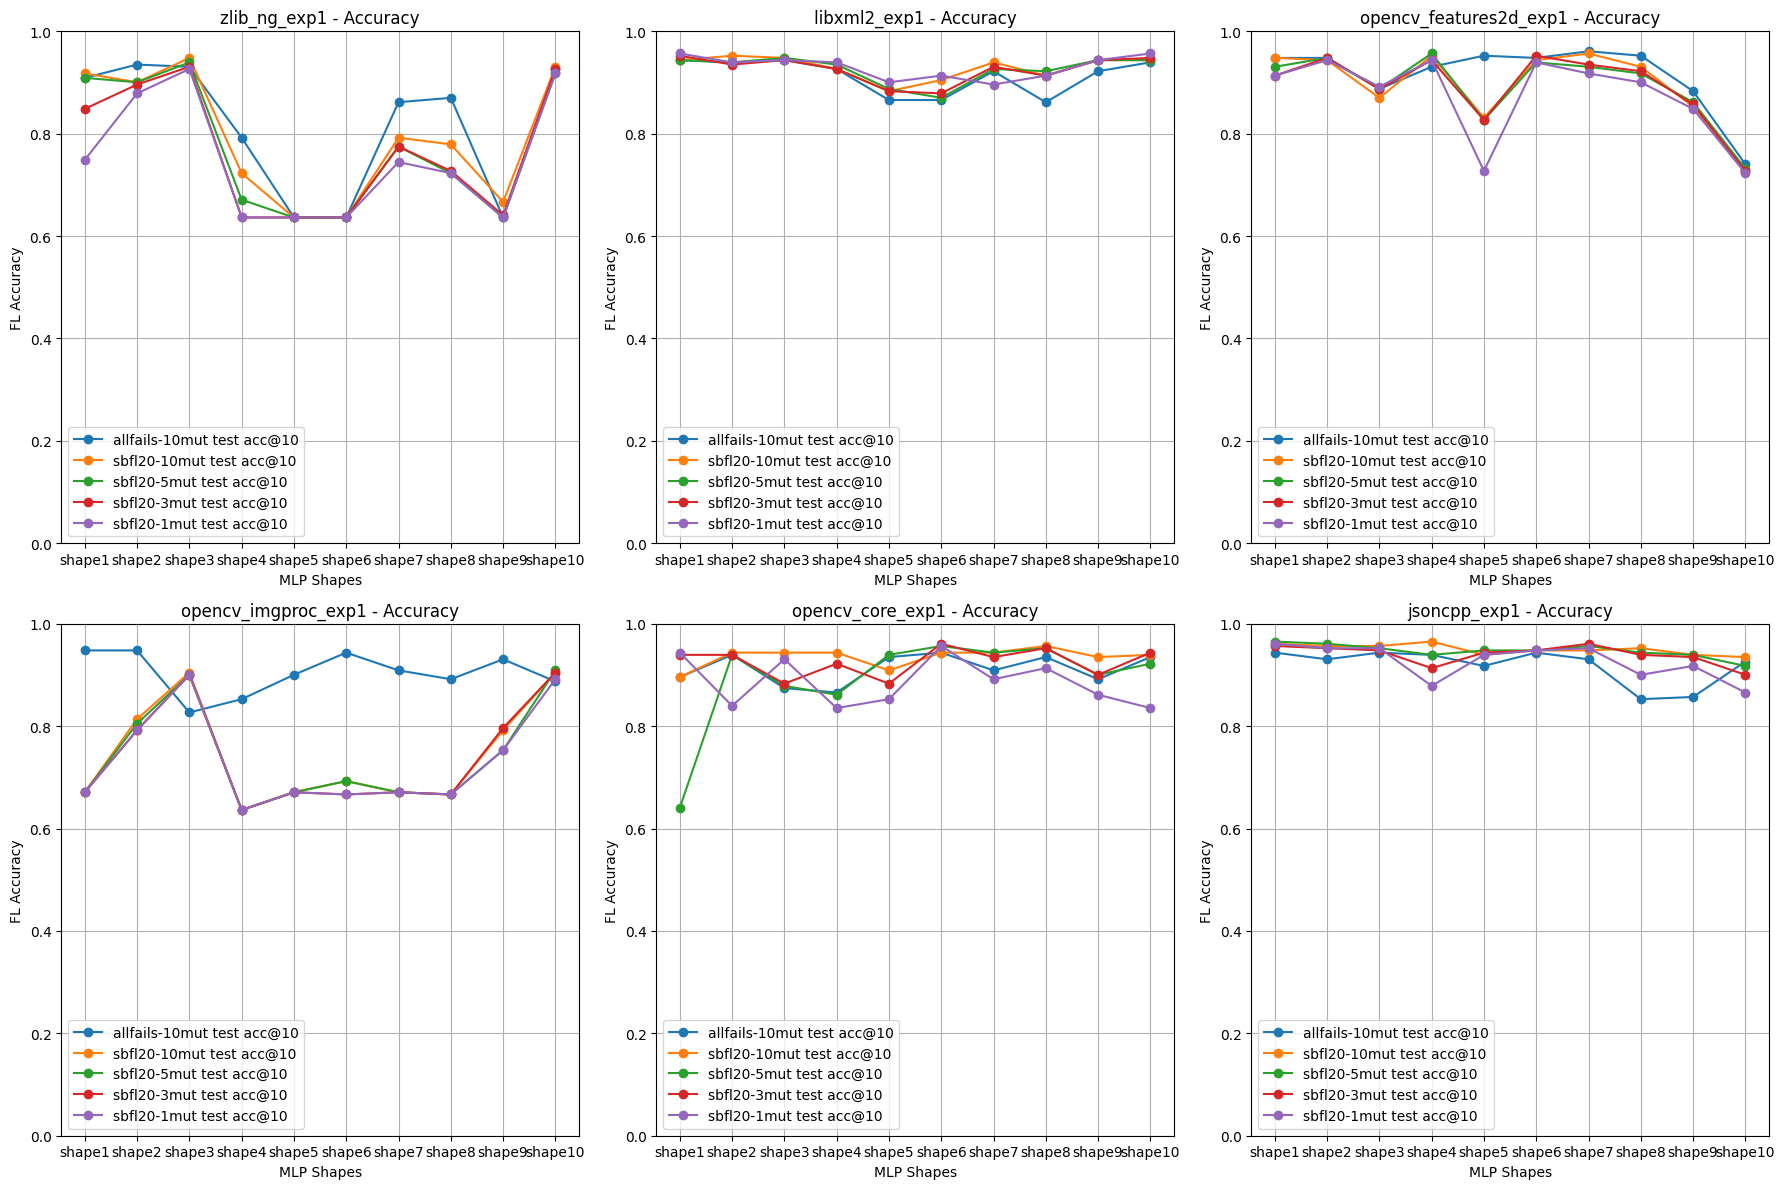

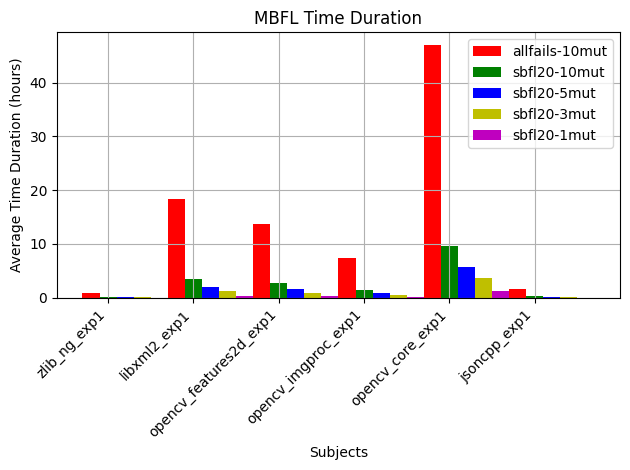

In [7]:
# RQ2: Number of Mutants Control
check_rq(RQ2_20, "RQ2_20")

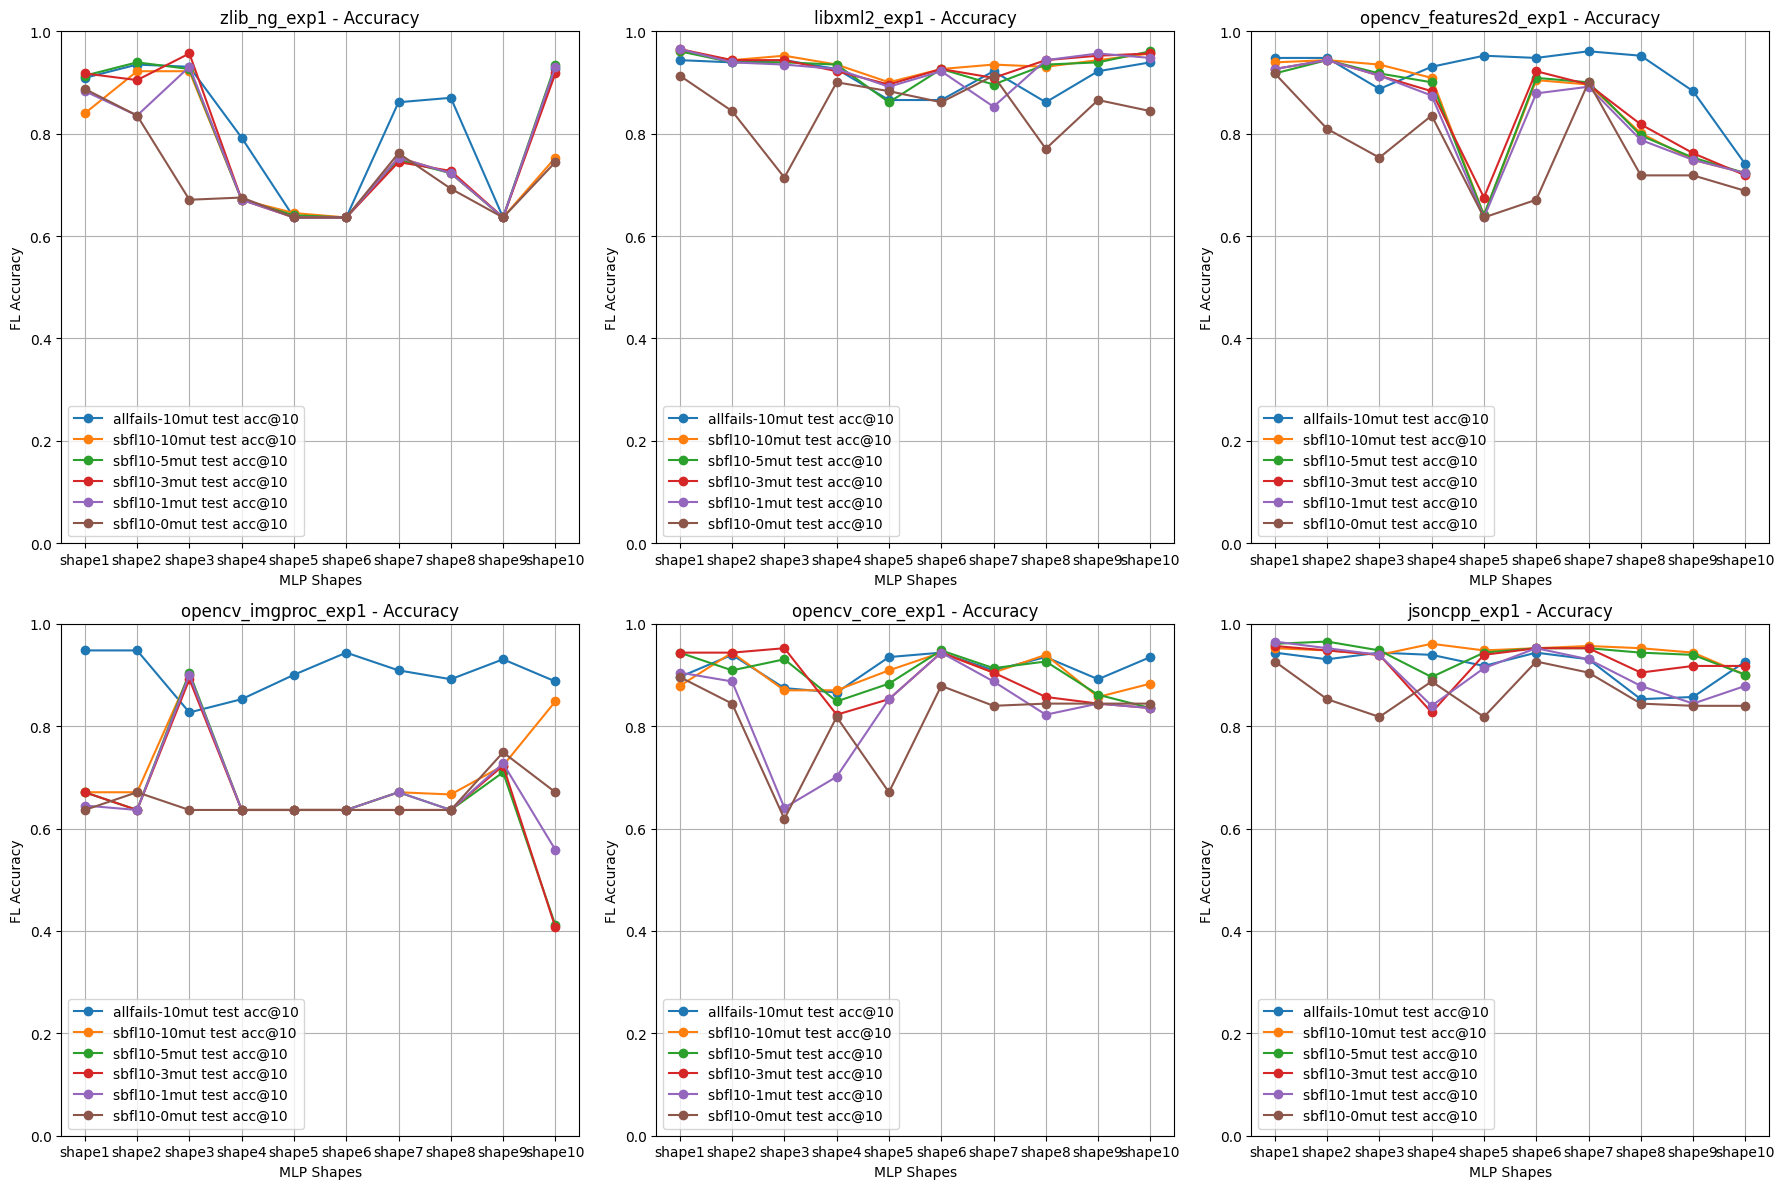

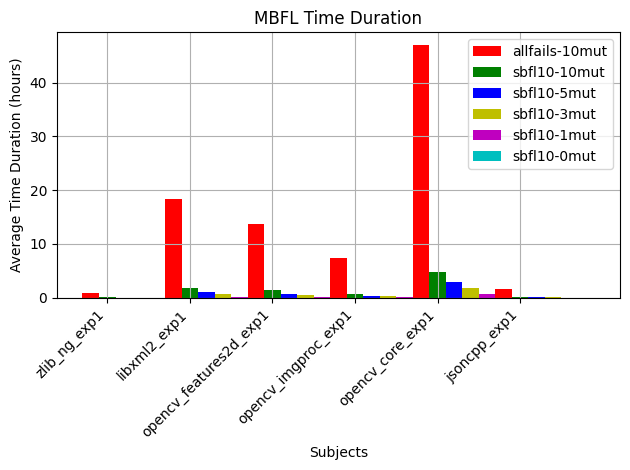

In [8]:
# RQ2: Number of Mutants Control
check_rq(RQ2_10, "RQ2_10")

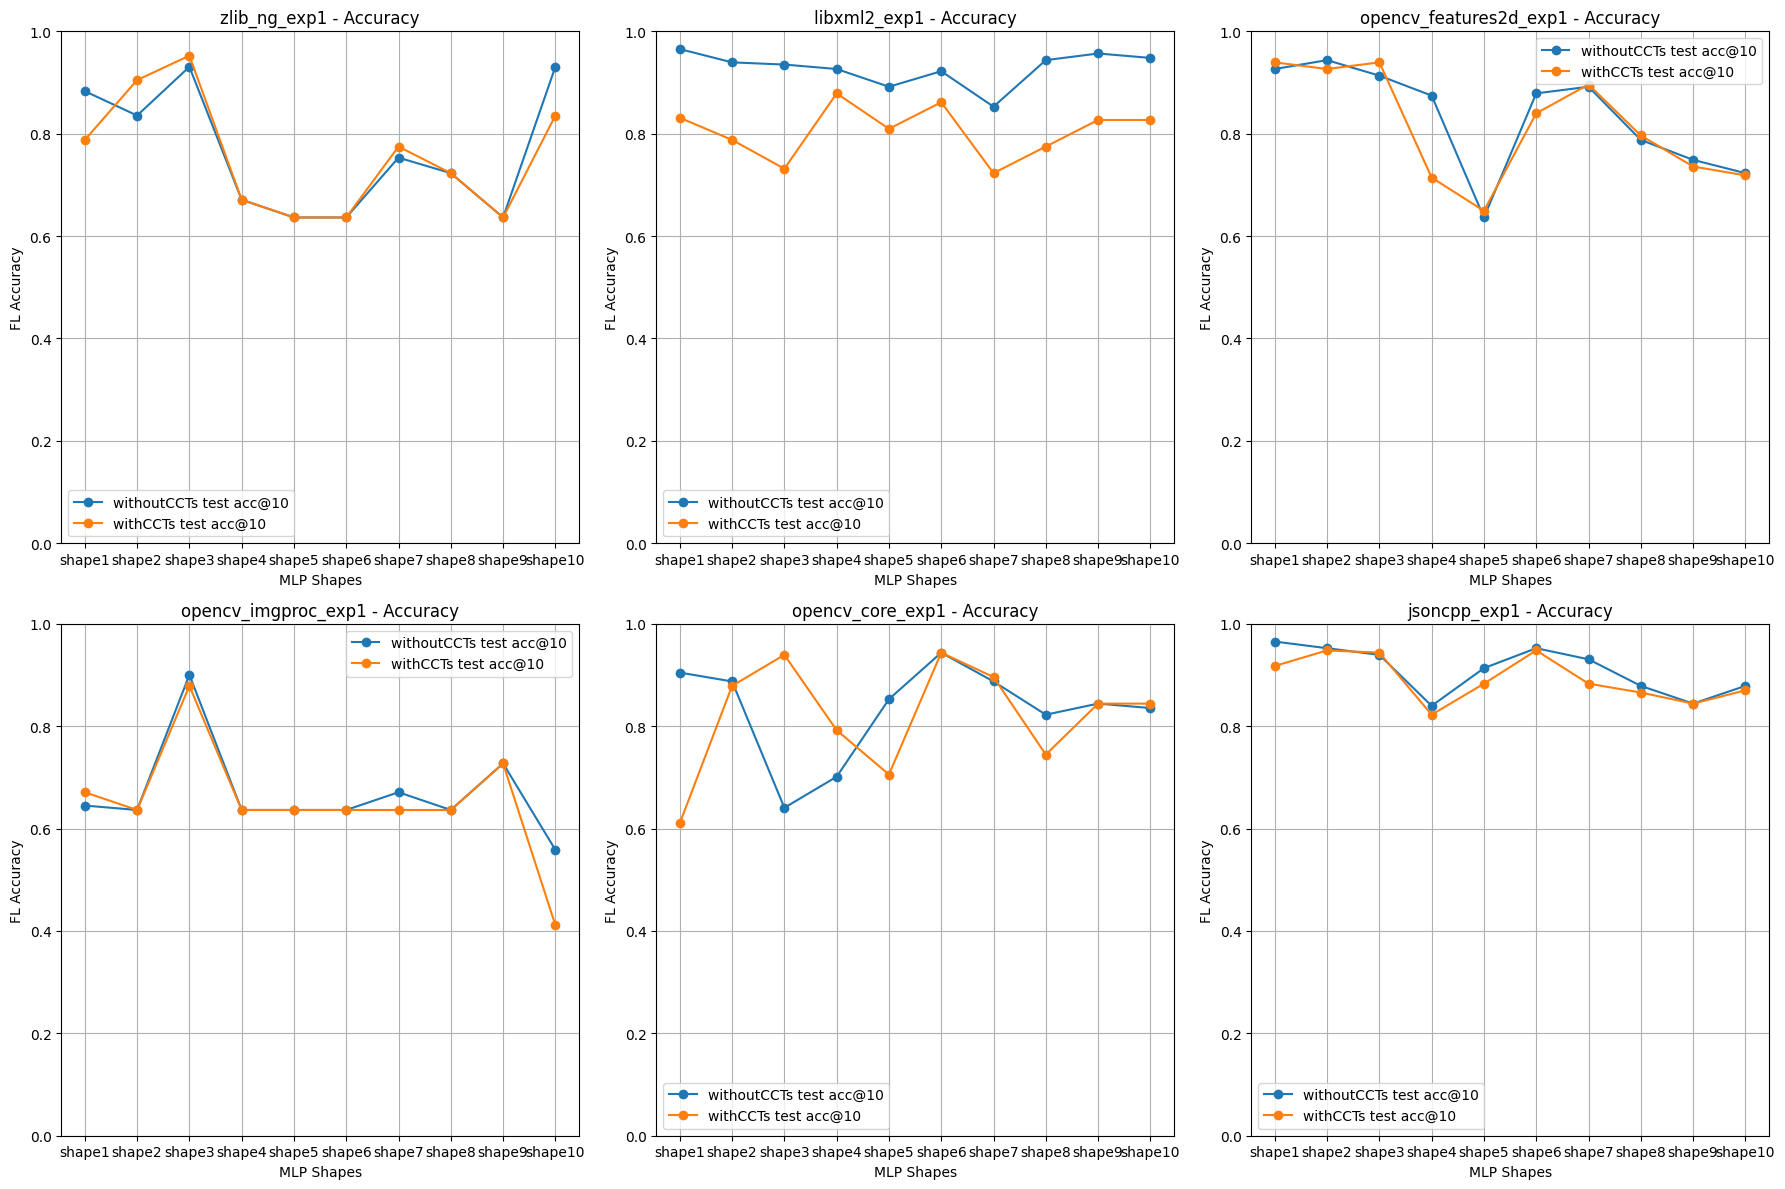

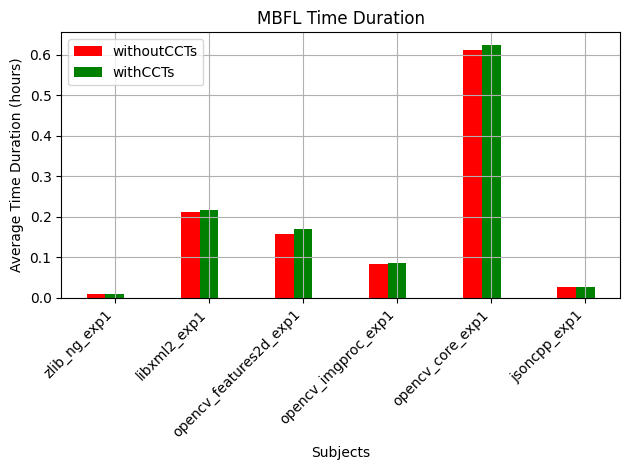

In [9]:
# RQ3: CCT
check_rq(RQ3, "RQ3")

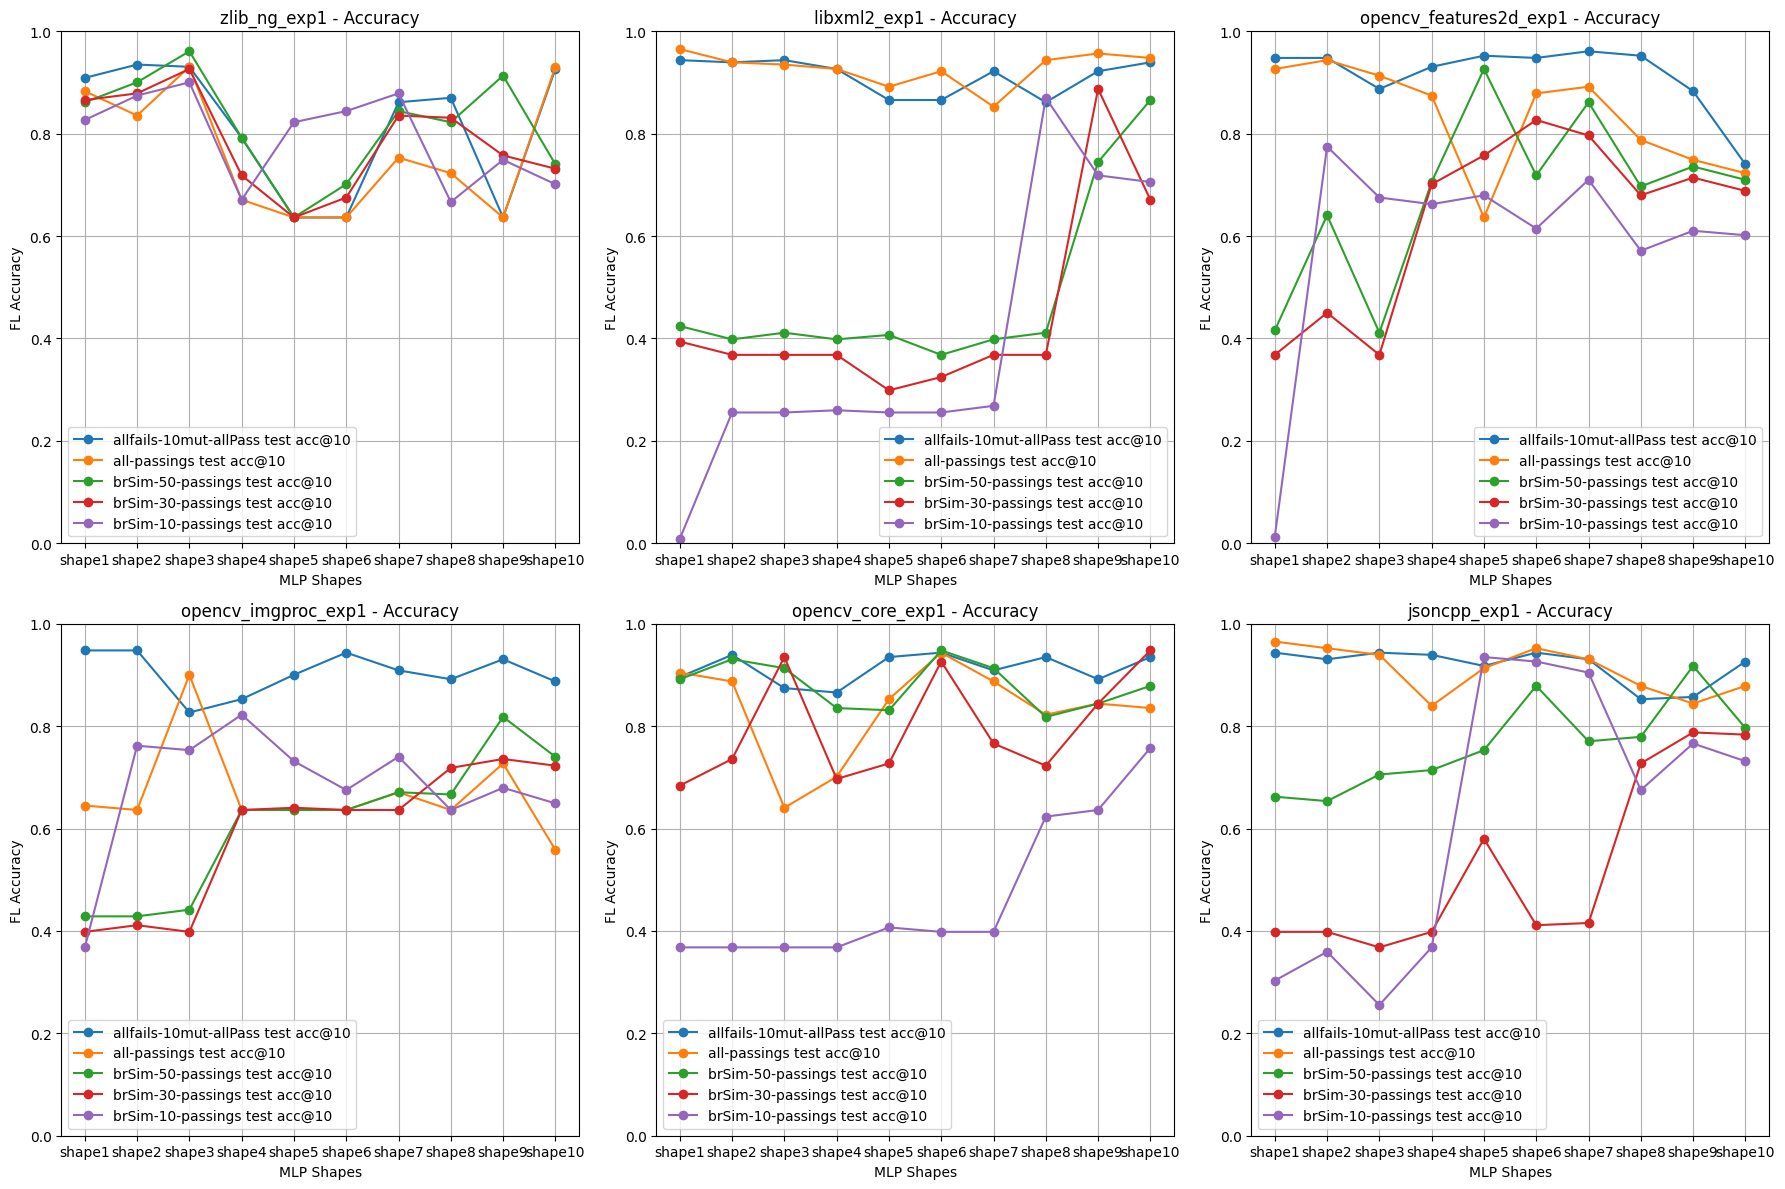

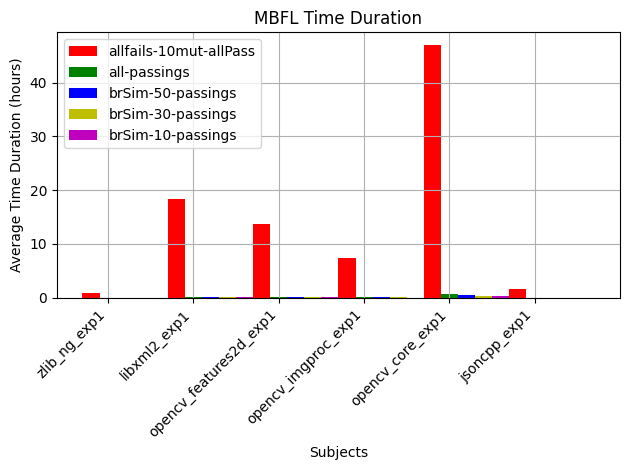

In [10]:
# RQ4: Reduced Passing Test Cases
check_rq(RQ4_10_branch, "RQ4_10_branch")

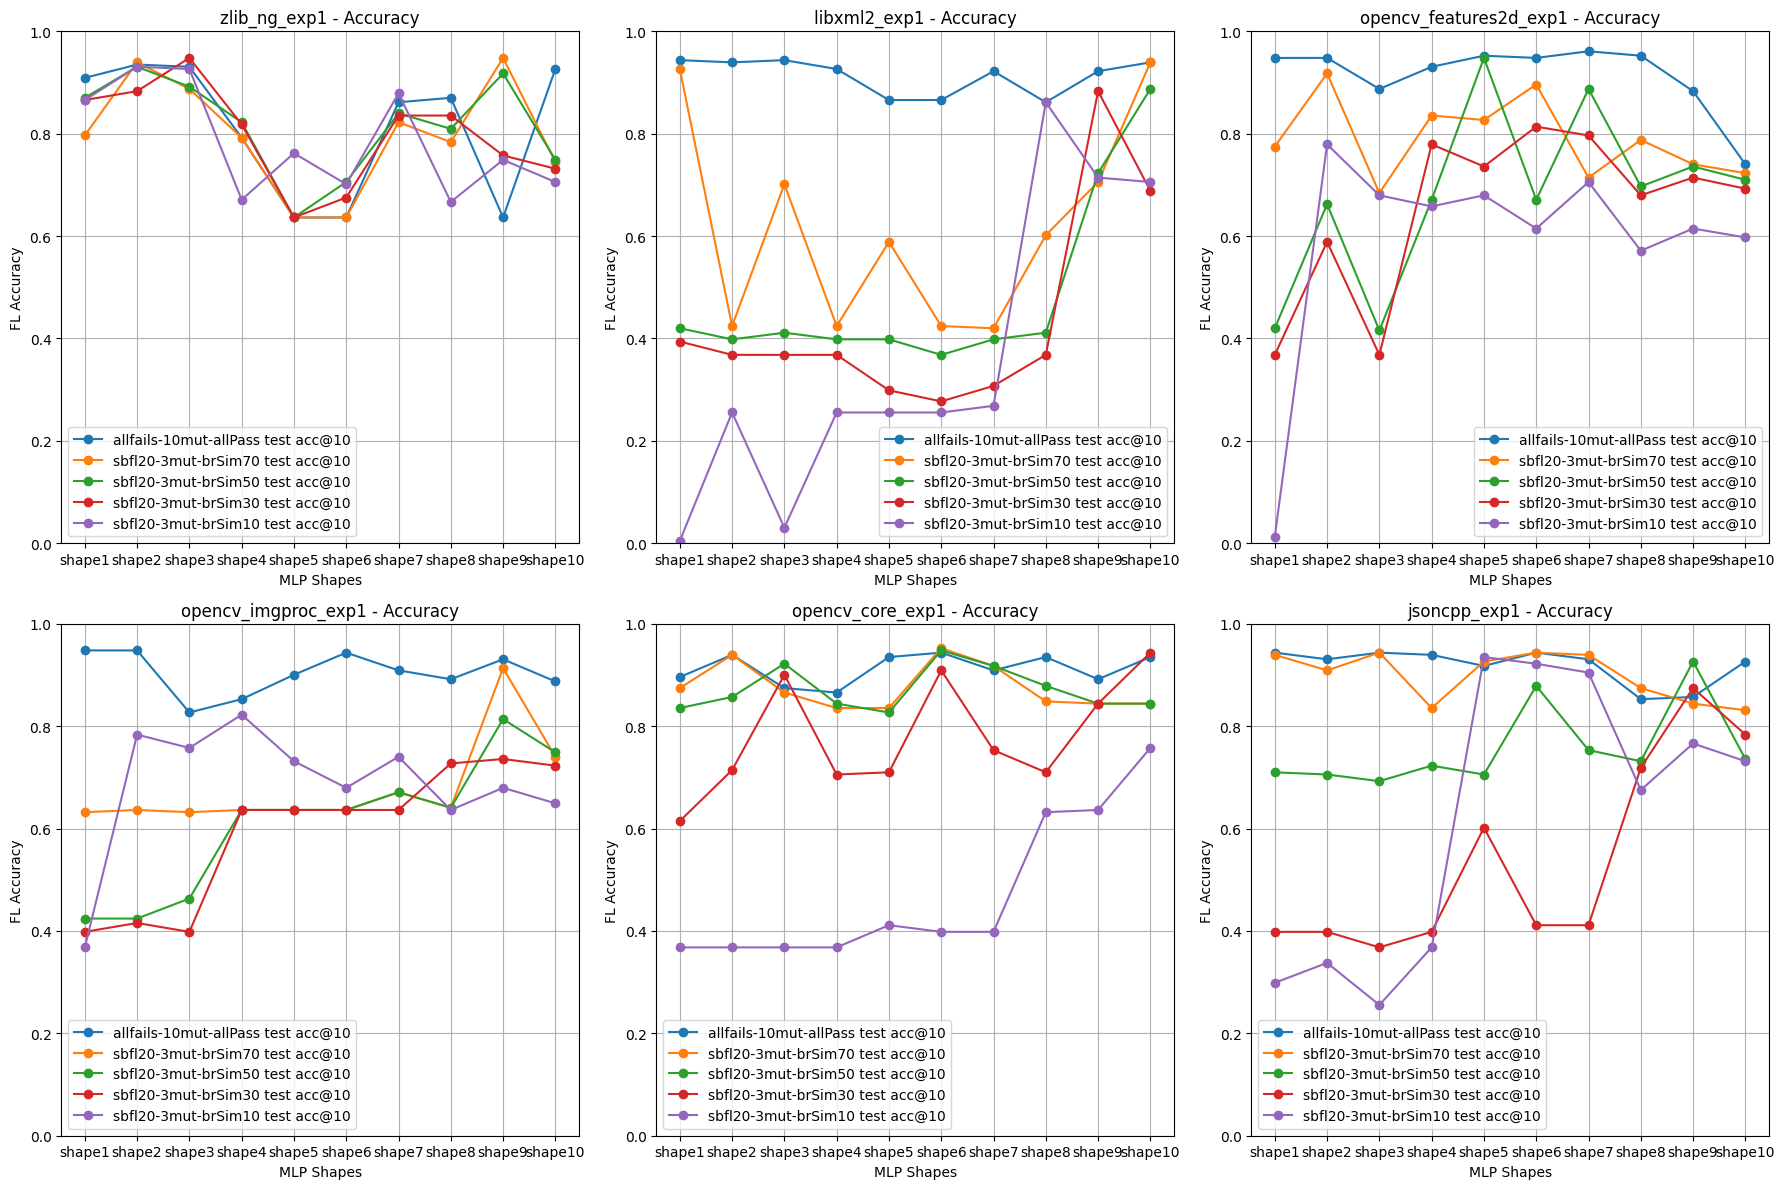

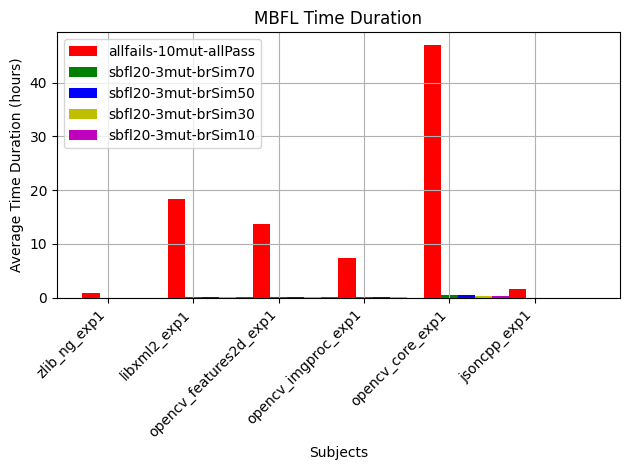

In [11]:
# RQ4: Reduced Passing Test Cases
check_rq(RQ4_20_branch, "RQ4_20_branch")

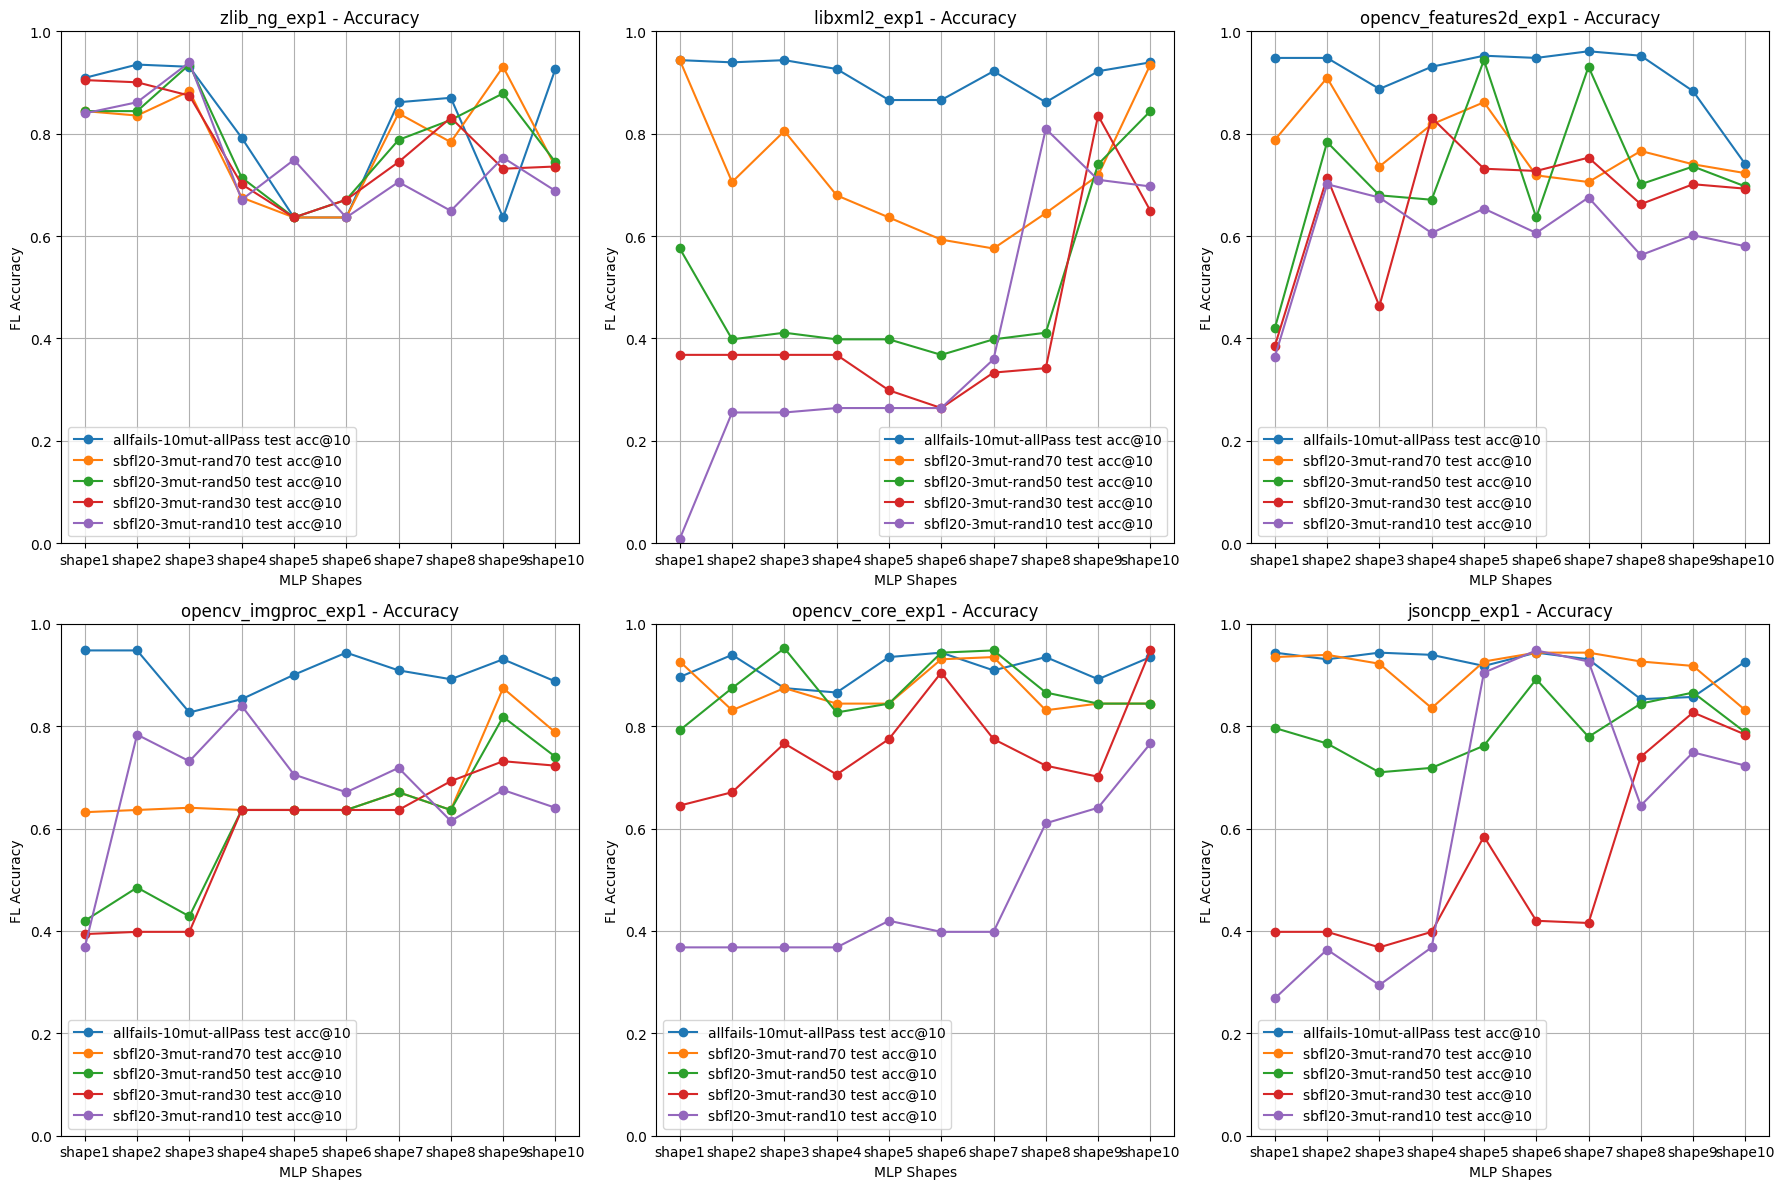

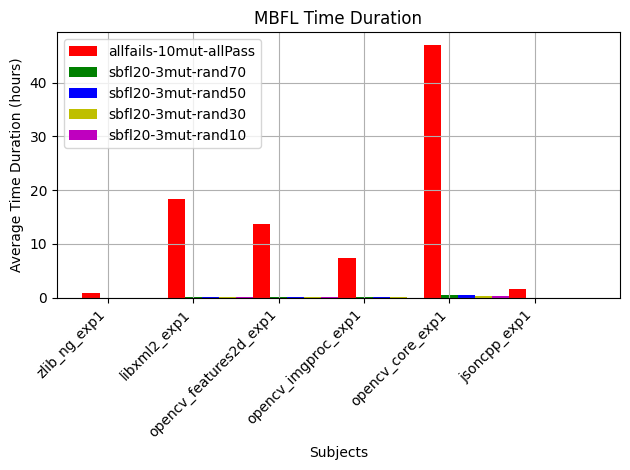

In [12]:
# RQ4: Reduced Passing Test Cases
check_rq(RQ4_20_random, "RQ4_20_random")